# Wavelet toy-model

This tutorial shows how to use the the WaveletSource instead of pixelated sources. For a more in-depth introduction to *scarlet*, read the [Core Concepts](1-concepts.ipynb) or the [API Documentation](api/index.rst).

In [1]:
# Import Packages and setup
import numpy as np
import scarlet
import scarlet.display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a superior colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gist_stern', interpolation='none')

## Load and Display Data

We load an example data set (here an image cube with 5 bands) *and* a detection catalog.
If such a catalog is not available packages like [SEP](http://sep.readthedocs.io/) and [photutils](https://photutils.readthedocs.io/en/stable/) will happily generate one, but for this example we use part of the detection catalog generated by the [LSST DM stack](https://github.com/lsst). 

In [2]:
# Load the sample images
data = np.load("../../data/hsc_cosmos_35.npz")
images = data["images"]
filters = data["filters"]
catalog = data["catalog"]
weights = 1/data["variance"]
psfs = scarlet.PSF(data["psfs"])

This shows how the wavelet transform and inverse transform works in scarlet. As a check we make sure that the transform and its inverse lead to the original image.

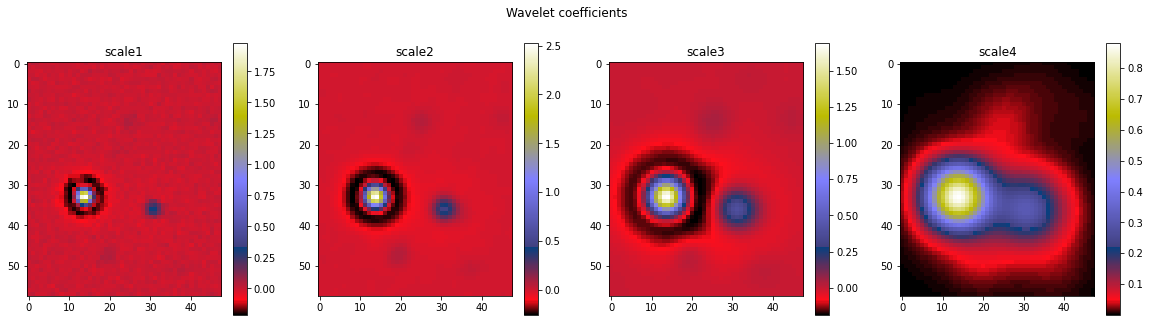

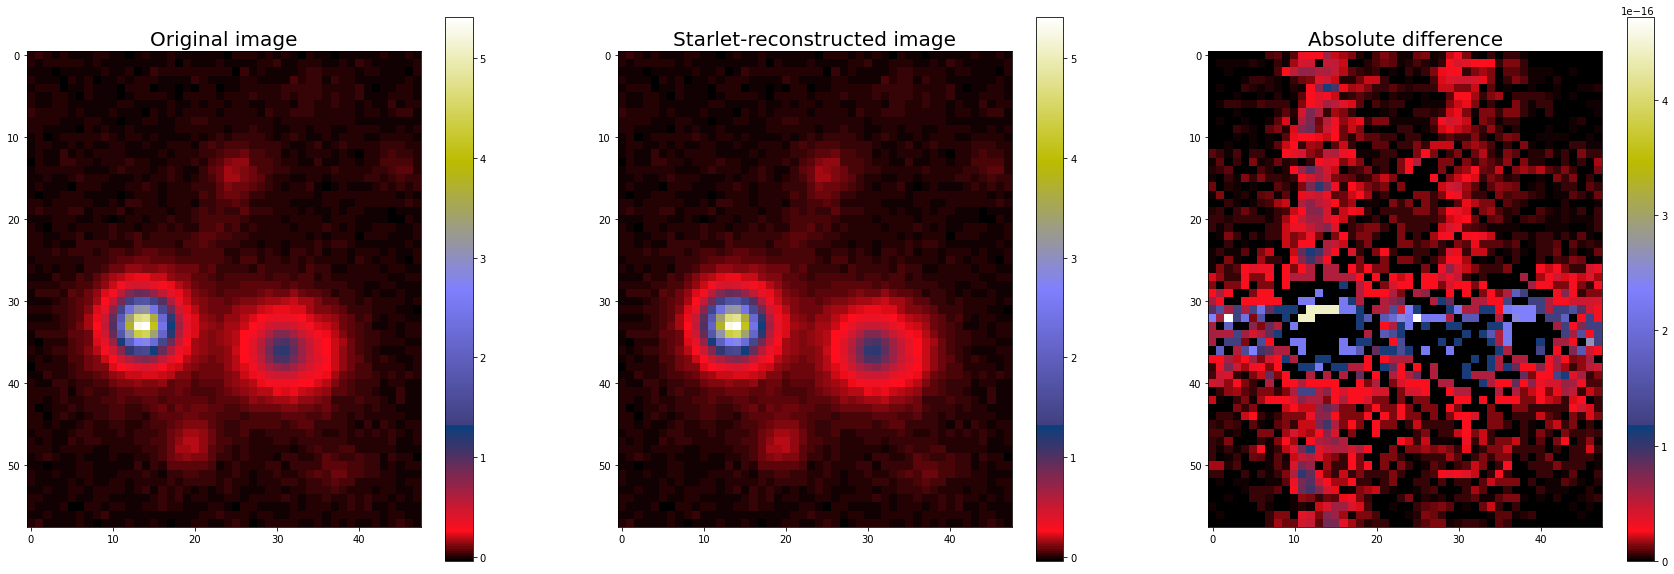

In [3]:
#Declare a starlet object (and performs the transform)
Sw = scarlet.Starlet(images, lvl = 4, direct = True)
#This is the starlet transform as an array
w = Sw.coefficients
#The inverse starlet transform of w (new object otherwise, the tranform is not used)
iw = Sw.image

#The wavelet transform of the first slice of images in pictures:
lvl = w.shape[1]
plt.figure(figsize = (lvl*5,5))
plt.suptitle('Wavelet coefficients')
for i in range(lvl):
    plt.subplot(1,lvl,i+1)
    plt.title('scale'+str(i+1))
    plt.imshow(w[0,i])
    plt.colorbar()
plt.show()

#Making sure we recover the original image:
plt.figure(figsize = (30,10))
plt.subplot(131)
plt.title('Original image', fontsize = 20)
plt.imshow(images[0])
plt.colorbar()
plt.subplot(132)
plt.title('Starlet-reconstructed image', fontsize = 20)
plt.imshow(iw[0])
plt.colorbar()
plt.subplot(133)
plt.title('Absolute difference', fontsize = 20)
plt.imshow((np.abs(iw[0]-images[0])))
plt.colorbar()
plt.show()

### Display Image Cube
This is an example of how to display an RGB image from an image cube of multiband data. In this case the image uses a $sinh^{-1}$ function to normalize the flux in each filter consistently to create an RGB image.

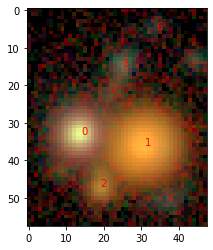

In [4]:
from scarlet.display import AsinhMapping

stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.imshow(img_rgb)

# Mark all of the sources from the detection cataog
for k, src in enumerate(catalog):
    plt.text(src["x"], src["y"], str(k), color="red")

## Define Model Frame and Observation

A `Frame` in *scarlet* is a description of the hyperspectral cube of the model or the observations. Think of it as the metadata, what aspects of the sky are described here. At the least, a `Frame` holds the `shape` of the cube, for which we use the convention `(C, Ny, Nx)` for the number of elements in 3 dimensions: `C` for the number of bands/channels and `Ny, Nx` for the number of pixels at every channel.

An `Observation` combines a `Frame` with several data units, similar to header-data arrangement in FITS files. In addition to the actual science image cube, you can and often must provide weights for all elements in the data cube, an image cube of the PSF model (one image for all or one for each channel), an `astropy.WCS` structure to translate from pixel to sky coordinates, and labels for all channels. The reason for specifying them is to enable the code to internally map from the model frame, in which you seek to fit a model, to the observed data frame.

In this example, we assume that bands and pixel locations are identical between the model and the observation. Because we have ground-based images with different PSFs in each band, we need to provide a reference PSF for the model. We simply choose a minimal Gaussian PSF that is barely well sampled as our reference kernel:

In [5]:
from functools import partial
model_psf = scarlet.PSF(partial(scarlet.psf.gaussian, sigma=.8), shape=(None, 8, 8))

With this we can fully specify the `Frame` and `Observation`:

In [6]:
model_frame = scarlet.Frame(
    images.shape,
    psfs=model_psf,
    channels=filters)

observation = scarlet.Observation(
    images, 
    psfs=psfs, 
    weights=weights, 
    channels=filters).match(model_frame)

The last command calls the `match` method to compute e.g. PSF difference kernel and filter transformations.

We generally recommend this pattern:
1. define model frame
2. construct observation
3. match it to the model frame

Steps 2 and 3 are combined above using a fluent pattern.

## Initialize sources

You now need to define sources that are going to be fit. The full model, which we will call `Blend`, is a collection of those sources. We provide several pre-built source types:

* `PointSource` fits centers and per-band amplitude using the observed PSF model.
* `WaveletSource` fits per-band amplitude and a non-parametric morphology in wavelet space and constrained in its L0 norm.


In [7]:
noise = scarlet.mad_wavelet(images)

sources = []
for k,src in enumerate(catalog):
    if k == 0:
        new_source = scarlet.PointSource(model_frame, (src['y'], src['x']), observation)
    else:
        new_source = scarlet.StarletSource(model_frame, (src['y'], src['x']), observation)
    sources.append(new_source)

## Create and Fit Model
The `Blend` class represents the sources as a tree and has the machinery to fit all of the sources to the given images. In this example the code is set to run for a maximum of 200 iterations, but will end early if the likelihood and all of the constraints converge.

CPU times: user 23.3 s, sys: 71.9 ms, total: 23.4 s
Wall time: 23.4 s
scarlet ran for 200 iterations to logL = 19461.64686710577


Text(0, 0.5, 'log-Likelihood')

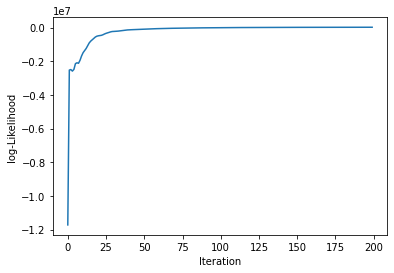

In [8]:
blend = scarlet.Blend(sources, observation)
%time blend.fit(200, e_rel = 1.e-6)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend.loss), -blend.loss[-1]))
plt.plot(-np.array(blend.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

## Interact with Results

### View Full Scene

We could use `scarlet.display.show_scene` to render to entire scene, but it's instructive to see how the model and the comparison to observations is performed.
First we load the model for the entire scene, render it in the observation frame, and compute its residuals. We then show model and data with the same $sinh^{-1}$ stretch and the residuals with a linear stretch.

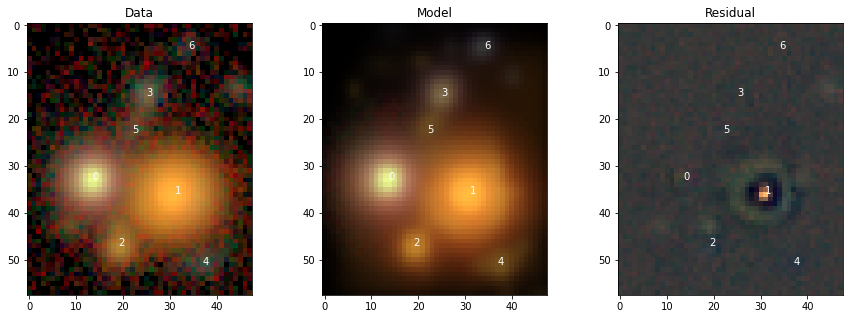

In [9]:
# Load the model and calculate the residual
model = blend.get_model()
model_ = observation.render(model)
residual = images-model_

# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")

for k,component in enumerate(blend):
    y,x = component.center
    ax[0].text(x, y, k, color="w")
    ax[1].text(x, y, k, color="w")
    ax[2].text(x, y, k, color="w")
plt.show()

### View Source Models

We will now inspect the model for each source, in its original frame and in its observed frame by leveraging the `show_sources` method:

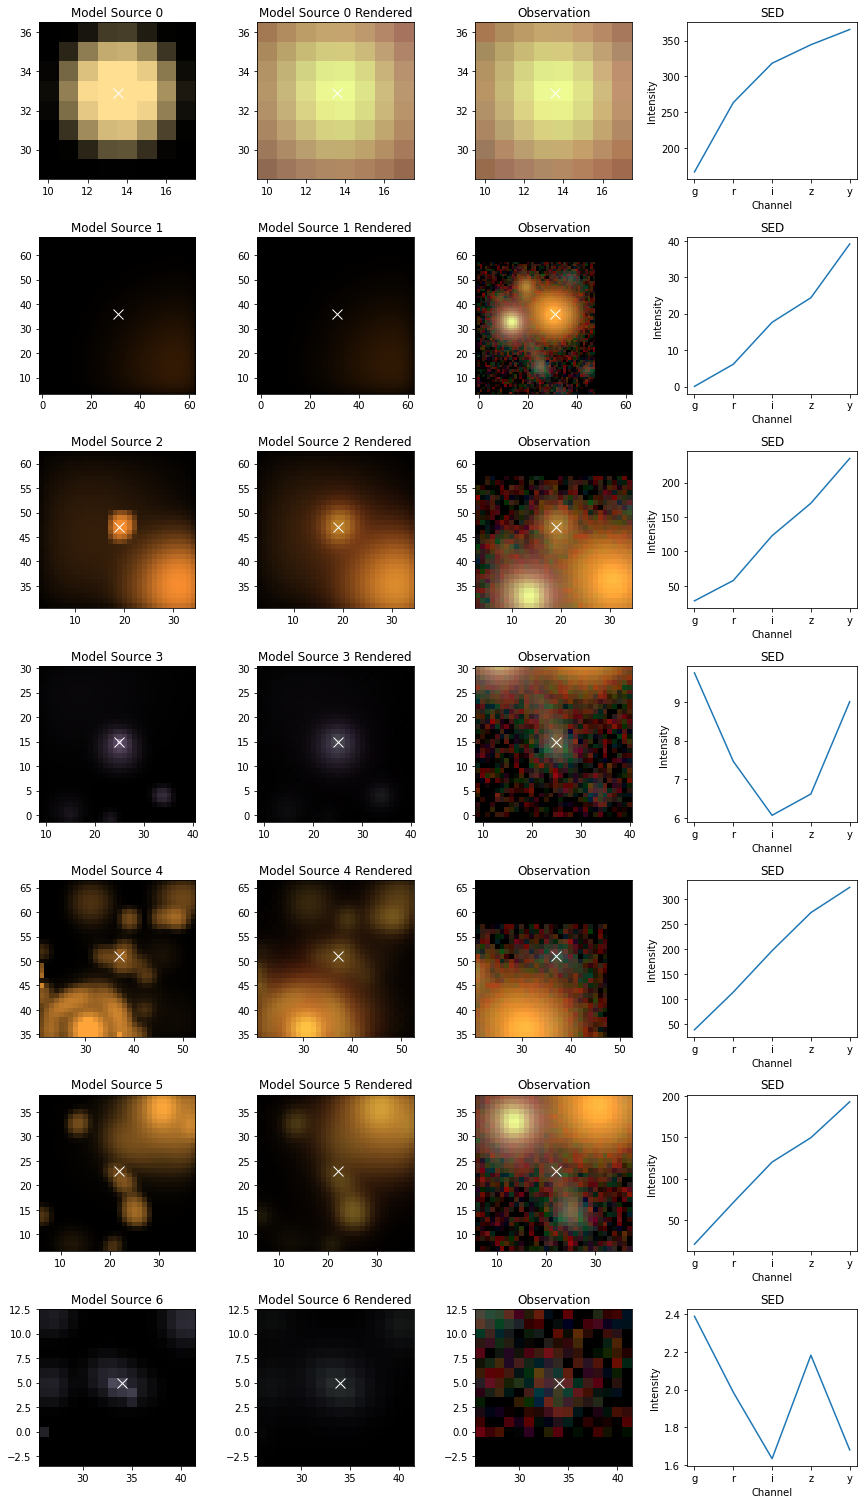

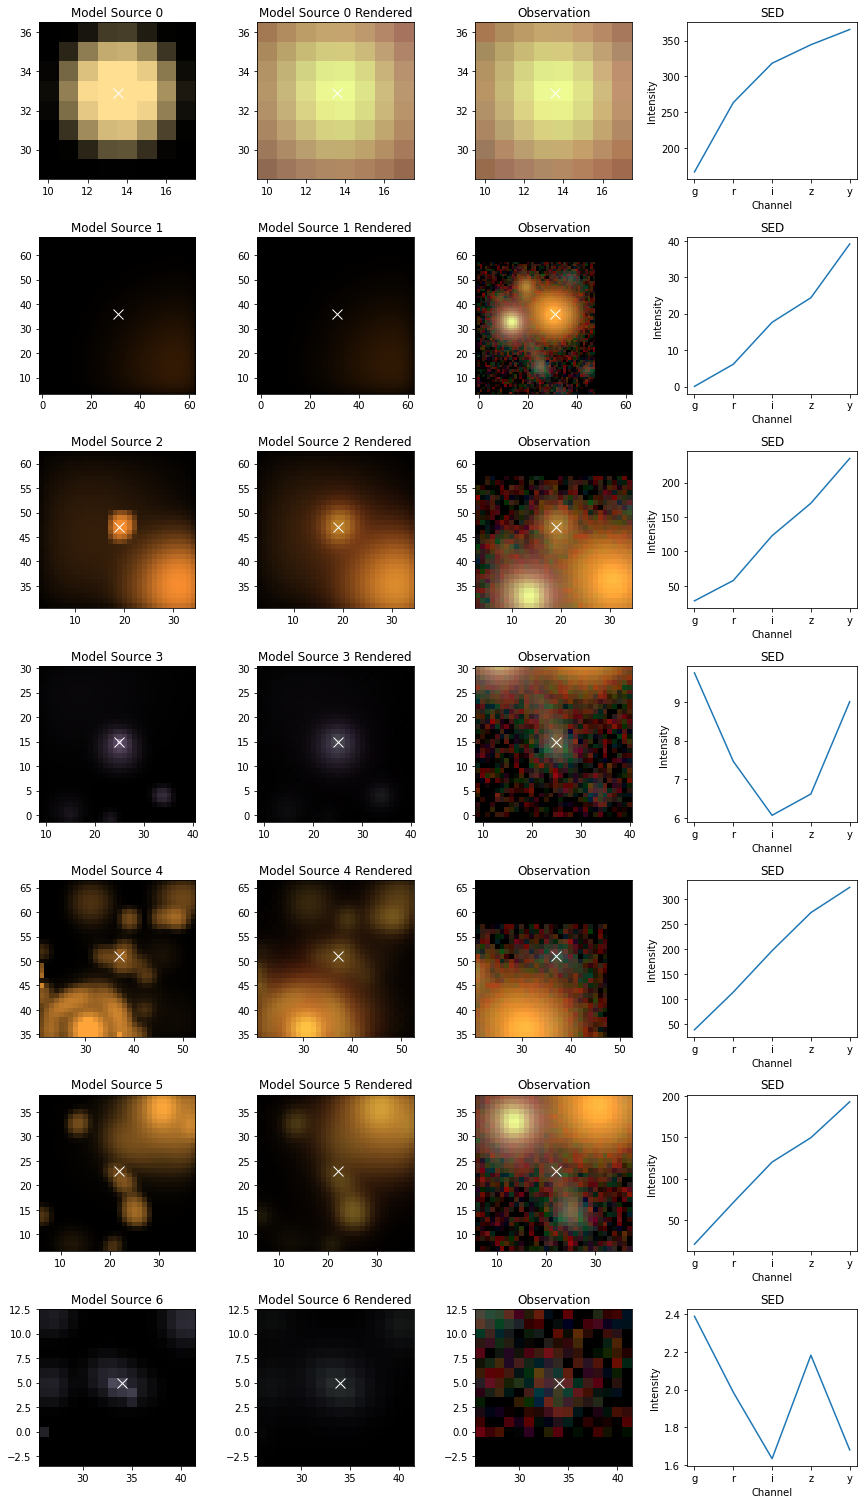

In [10]:
scarlet.display.show_sources(sources, 
                             norm=norm, 
                             observation=observation,
                             show_rendered=True, 
                             show_observed=True)

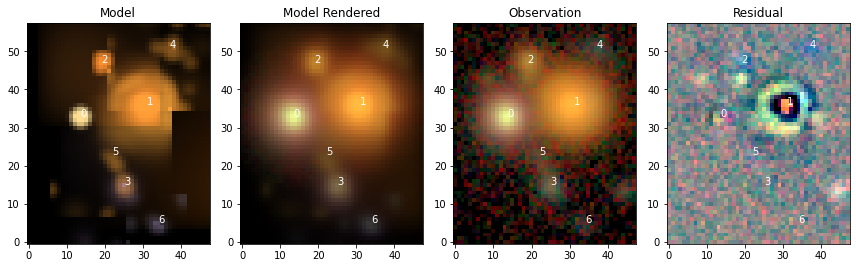

In [11]:
scarlet.display.show_scene(sources, 
                           norm=norm, 
                           observation=observation, 
                           show_rendered=True, 
                           show_observed=True, 
                           show_residual=True)
plt.show()